We then used the model trained previously to classify all historical maps from our study area. In order to reduce noise and make predictions smoother, some post-processing steps are required. For this, we used morphological operations such as **closing**, and **erosion**, as well as **low-pass filtering** with suitable kernel sizes.

# Postprocessing

In [ ]:
import cv2
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np

The postprocessing steps depend on the land cover class and how they are layered in the final products. Roads and waterways are such classes that the final products for these are line geometries, whereas the other classes can be either raster data or polygon data. Most waterways (e.g. ditches) do not split marshes and fields into multiple sections, whereas roads split these classes into multiple different segments. 

In [ ]:
ex_data = '../results/raw/213406_1965_ei_rajoja.tif'
with rio.open(ex_data) as src:
    data = src.read(1)
    
ex_map = '../data/maps/aligned_maps/213406_1965_ei_rajoja.tif'
with rio.open(ex_map) as src:
    mapdata = np.moveaxis(src.read(), 0, -1)

## Fields

During postprocessing, include waterways for these layers. `MORPH.OPEN` (erosion followed by dilation) with 11x11 kernel is sufficient to remove waterways from non-field areas.

<matplotlib.image.AxesImage>

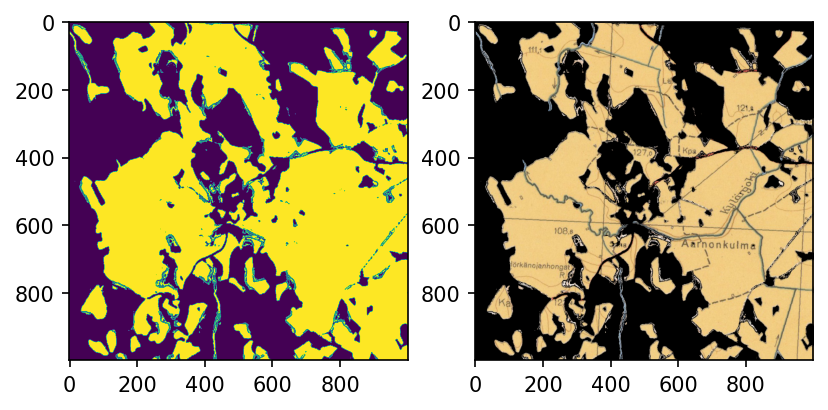

In [ ]:
fields = np.empty(data.shape)
fields[data==1] = 1
fields[data==4] = 1
fields = fields[200:1200, 4000:5000]
fields = fields.astype(np.uint8)
fig, axs = plt.subplots(1, 2, dpi=150)
tempmap = mapdata[200:1200, 4000:5000,:].copy()
tempmap[fields != 1] = 0
axs[0].imshow(fields)
axs[1].imshow(tempmap)

Comparison with automatically extracted orange color.

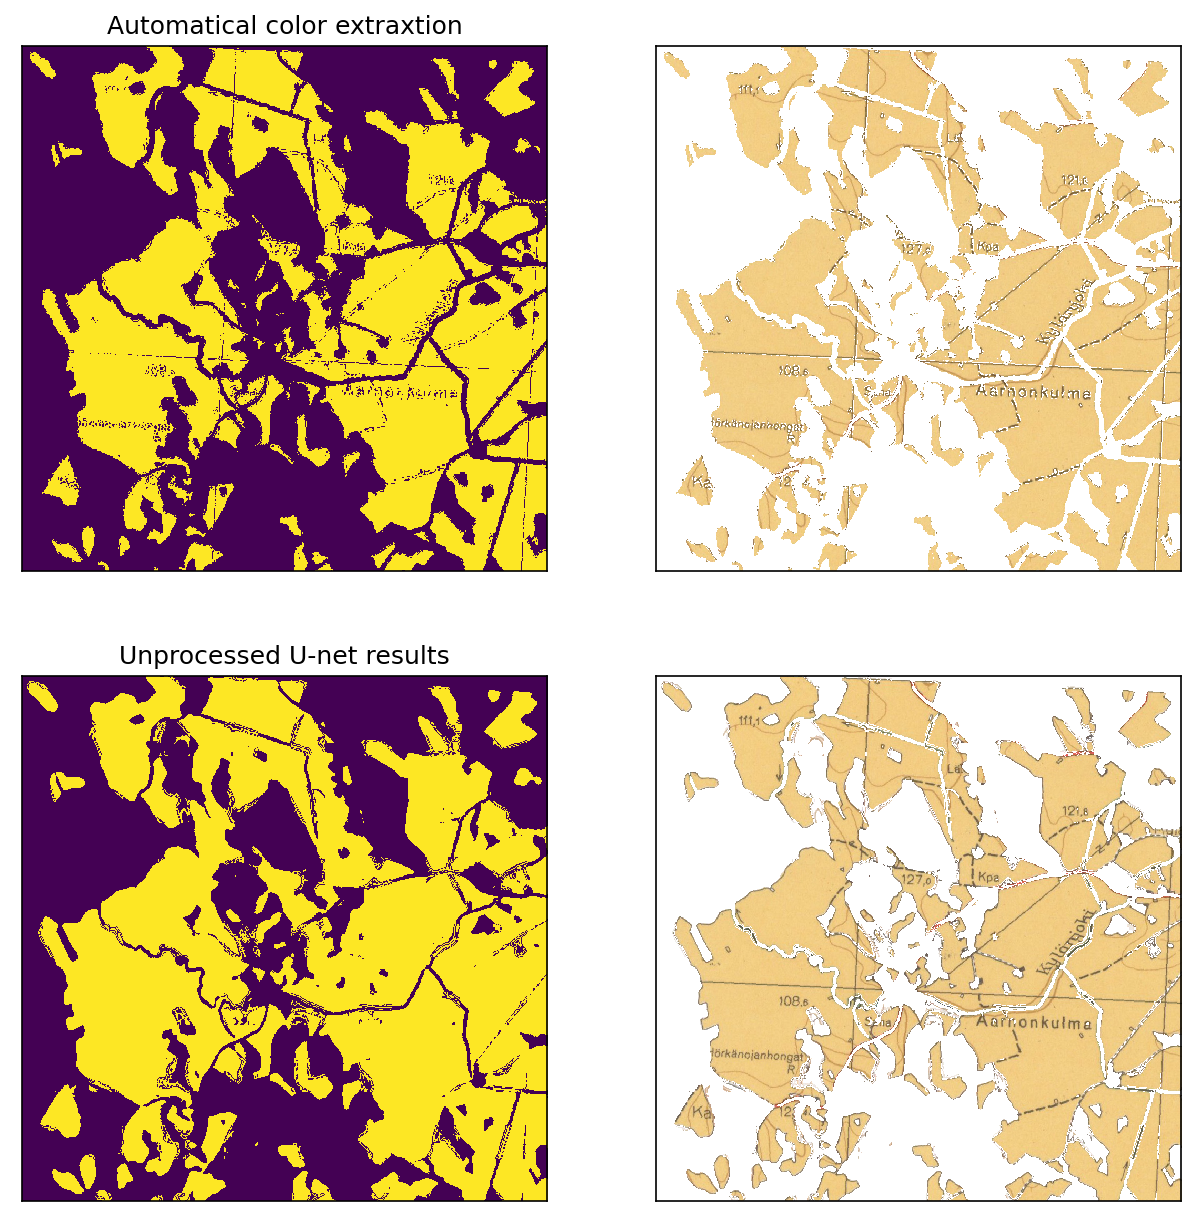

In [ ]:
hsv_field_bot = np.array([10,100,100])
hsv_field_top = np.array([25,255,255])
hsv_ex = cv2.cvtColor(tempmap, cv2.COLOR_RGB2HSV)
field_mask = cv2.inRange(hsv_ex, hsv_field_bot, hsv_field_top)
field_mask = field_mask.astype(np.int16)

fig, axs = plt.subplots(2,2, figsize=(10,10), dpi=150)

for a in axs.flatten(): 
    a.set_xticks([])
    a.set_yticks([])

field_mask[field_mask<128] = 0
field_mask[field_mask>128] = 1
axs[0,0].imshow(field_mask, interpolation='none')
temp = tempmap.copy()
temp[field_mask == 0] = 255
axs[0,1].imshow(temp, interpolation='none')

axs[0,0].set_title('Automatical color extraxtion')
axs[1,0].set_title('Unprocessed U-net results')
fields = np.empty(data.shape)
fields[data==1] = 1
fields = fields[200:1200, 4000:5000]
axs[1,0].imshow(fields, interpolation='none')
temp = tempmap.copy()
temp[fields == 0] = 255
axs[1,1].imshow(temp, interpolation='none')
plt.show()

Example postprocessing chain looks like this.

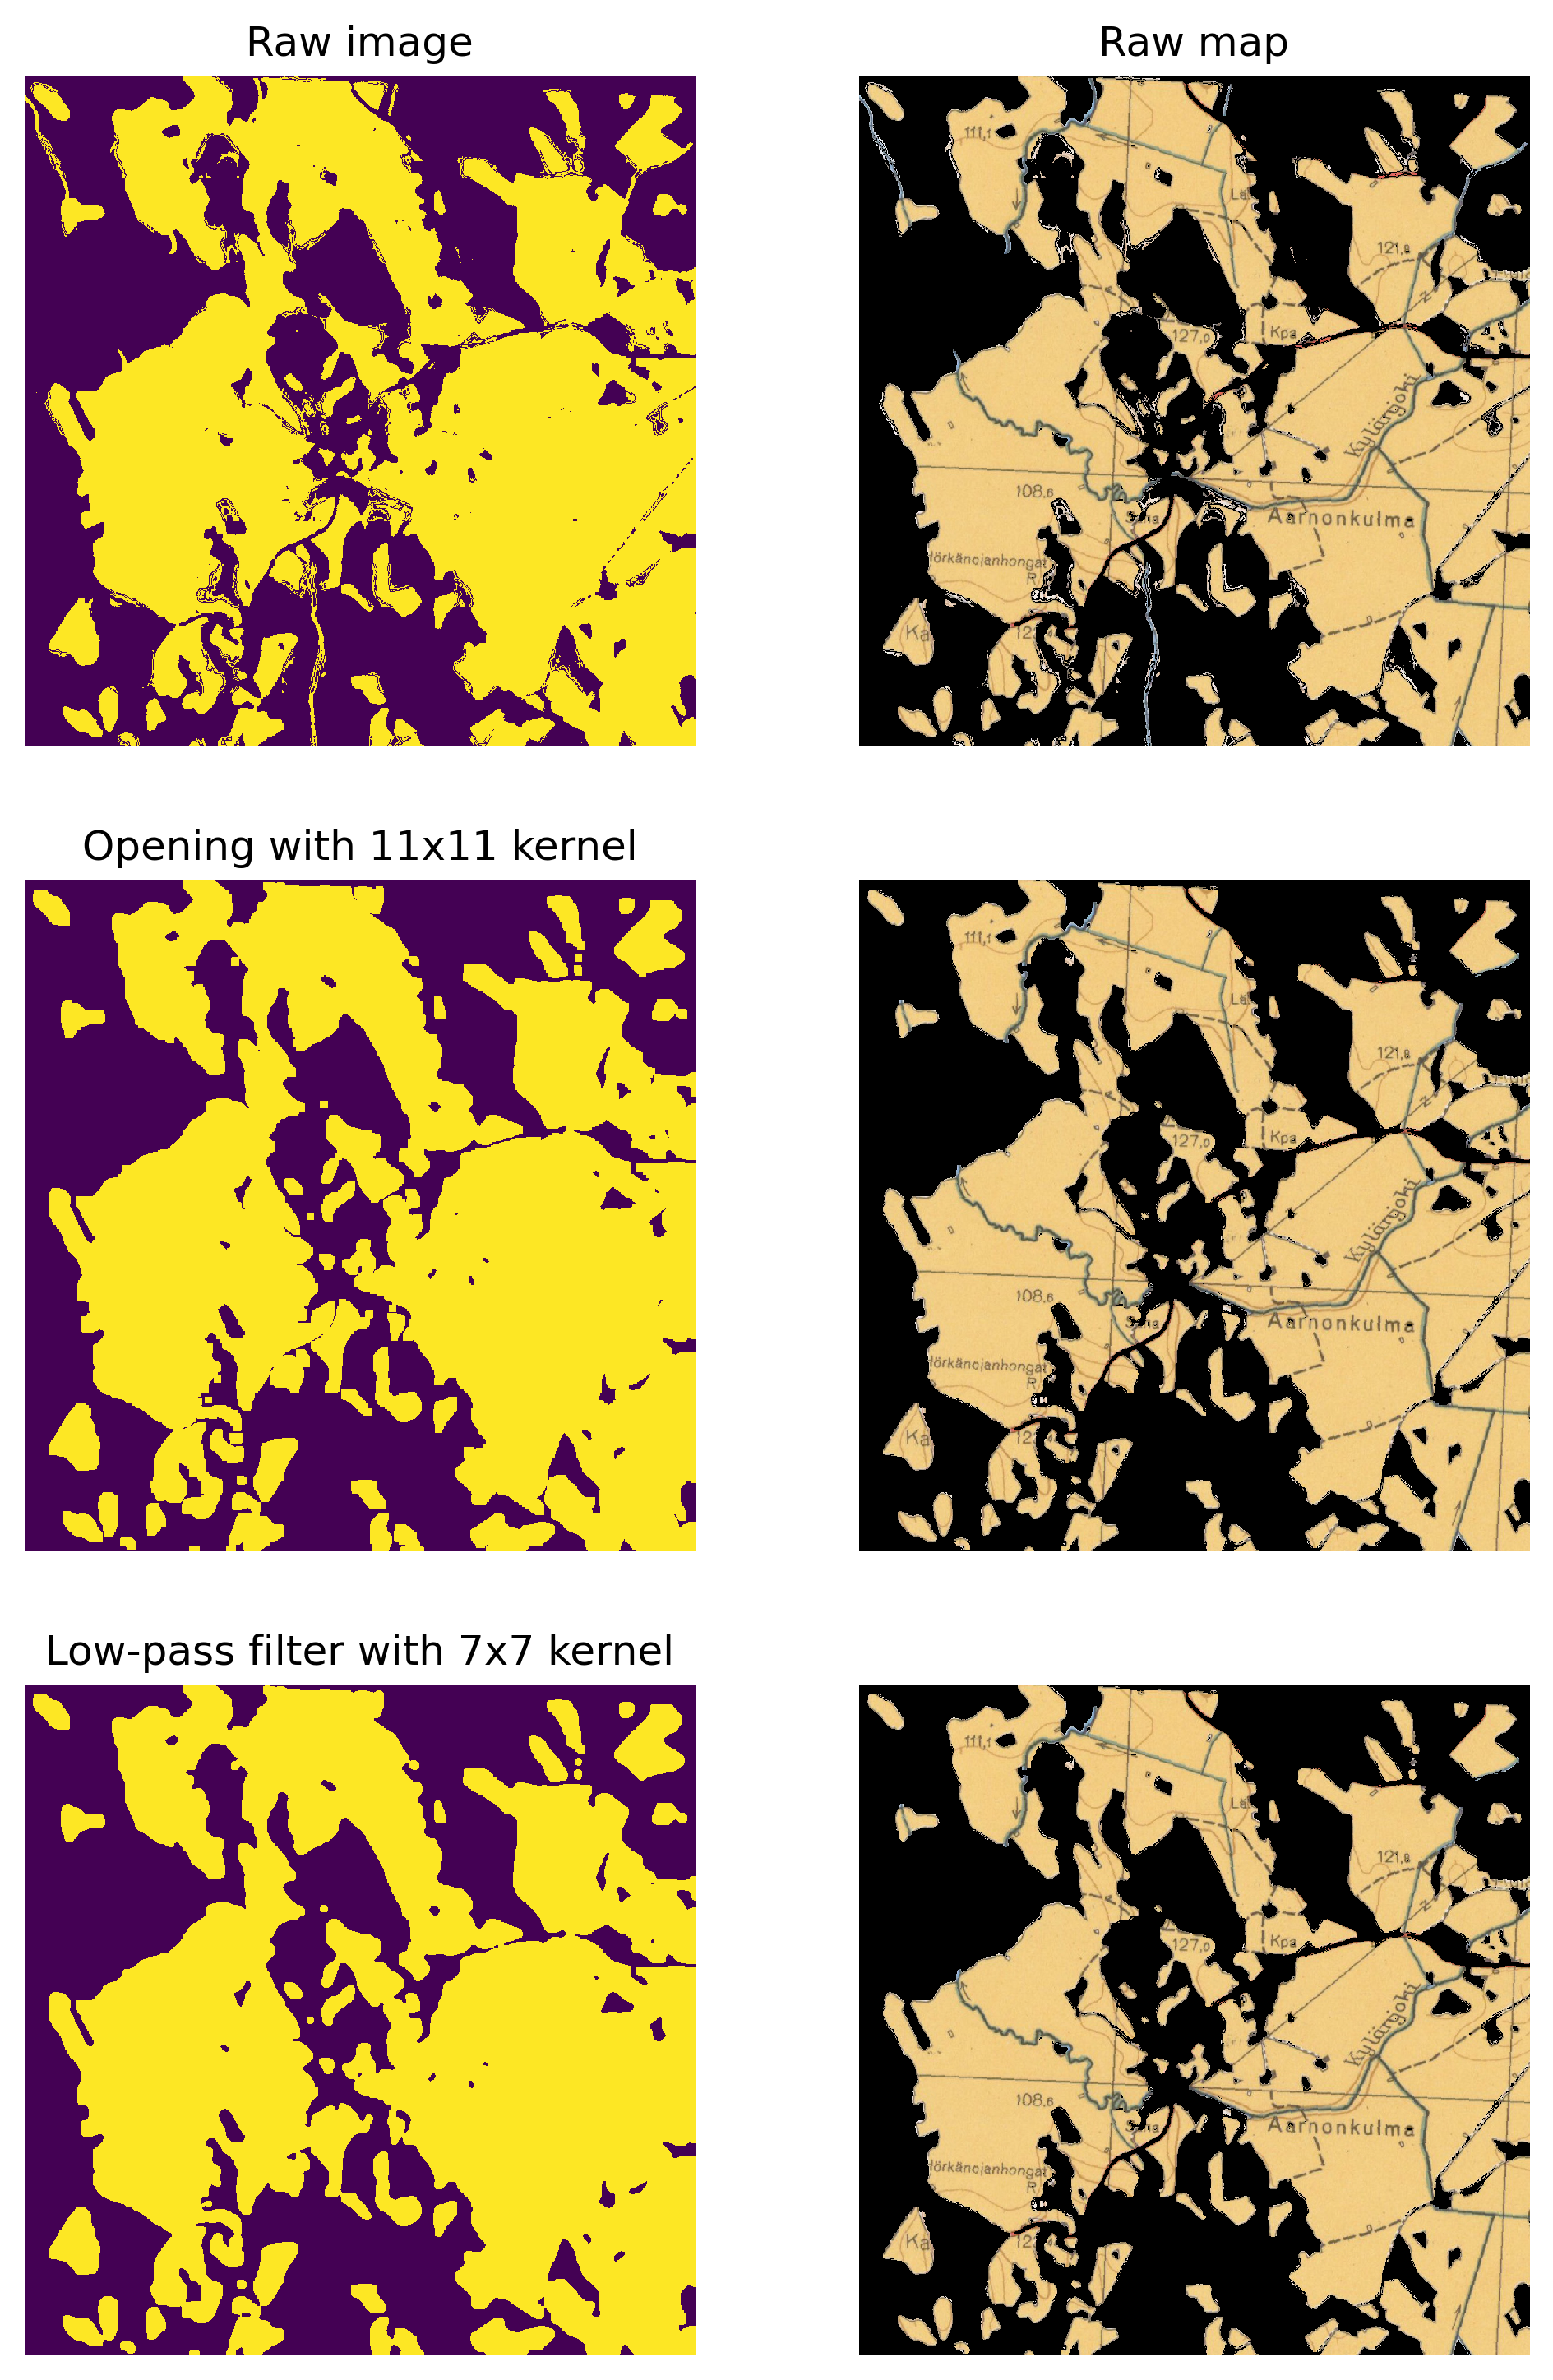

In [ ]:
fig, axs = plt.subplots(3,2, dpi=300, figsize=(8,12))
for a in axs.flatten(): a.axis('off')
    
axs[0,0].imshow(fields, interpolation='none')
axs[0,0].set_title('Raw image')
axs[0,1].set_title('Raw map')
axs[0,1].imshow(tempmap, interpolation='none')
er_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (11,11))
dil_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11,11))
open_ex = cv2.erode(fields, er_kernel)
open_ex = cv2.dilate(open_ex, dil_kernel)
#kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (11,11))
#open_ex = cv2.morphologyEx(fields, cv2.MORPH_OPEN, kernel)
axs[1,0].imshow(open_ex, interpolation='none')
axs[1,0].set_title('Opening with 11x11 kernel')

temp_open = tempmap.copy()
temp_open[open_ex != 1] = 0

axs[1,1].imshow(temp_open, interpolation='none')

lpf_kernel = np.ones((7,7), np.float32)/49

lpf_ex = cv2.filter2D(open_ex, -1, lpf_kernel)

axs[2,0].imshow(lpf_ex, interpolation='none')
axs[2,0].set_title('Low-pass filter with 7x7 kernel')

temp_lpf = temp_open.copy()
temp_lpf[lpf_ex != 1] = 0

axs[2,1].imshow(temp_lpf, interpolation='none')

plt.show()

## Marshes

Similar to fields, waterways running through marshes do not split marshes into multiple sections.

<matplotlib.image.AxesImage>

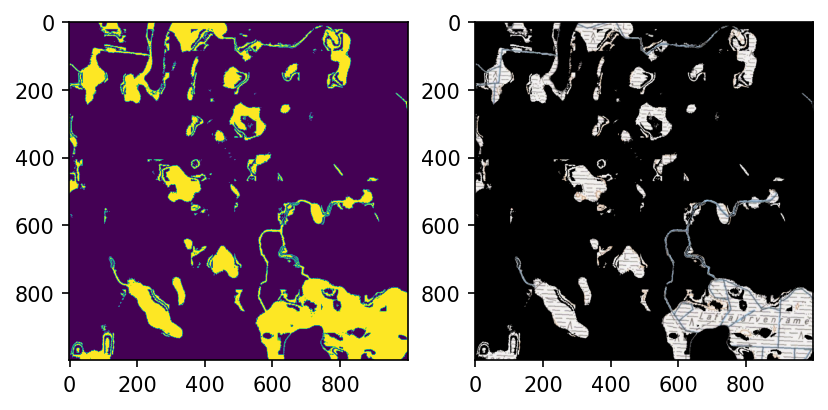

In [ ]:
marshes = np.empty(data.shape)
marshes[data==2] = 1
marshes[data==4] = 1
marshes = marshes[5000:6000, 3000:4000]
marshes = marshes.astype(np.uint8)
fig, axs = plt.subplots(1, 2, dpi=150)
tempmap = mapdata[5000:6000, 3000:4000,:].copy()
tempmap[marshes != 1] = 0
axs[0].imshow(marshes)
axs[1].imshow(tempmap)

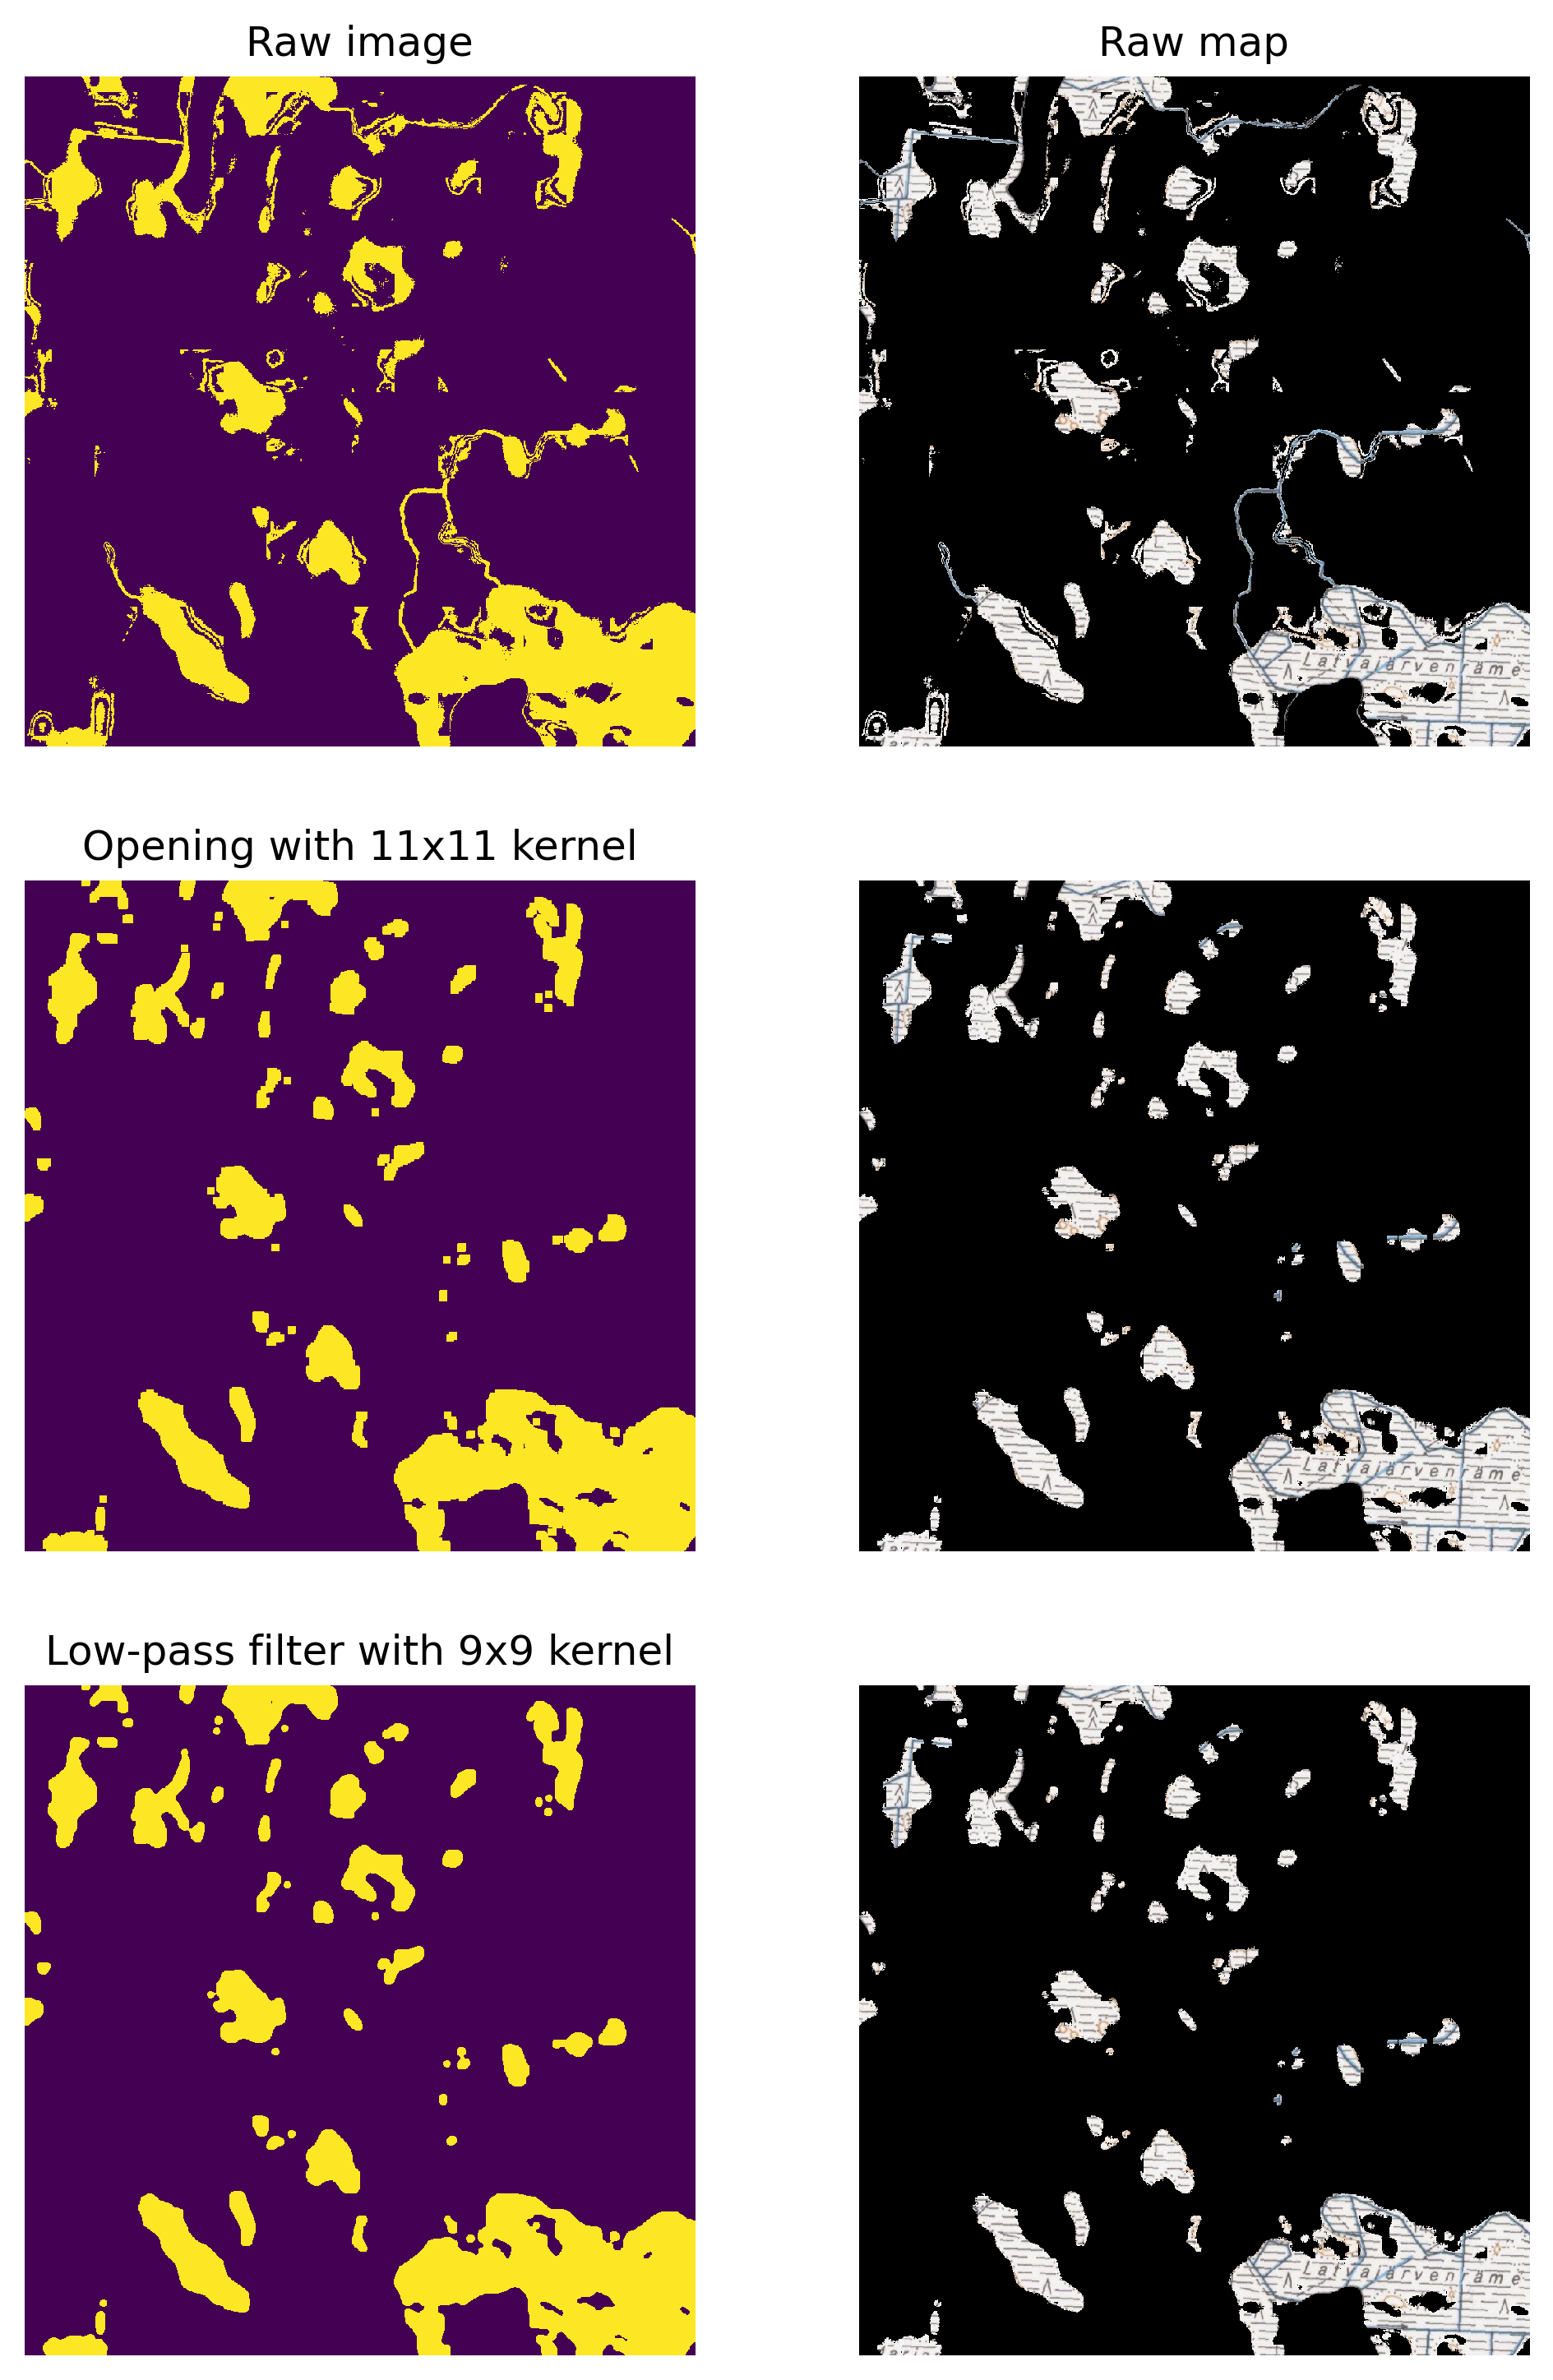

In [ ]:
fig, axs = plt.subplots(3,2, dpi=300, figsize=(8,12))
for a in axs.flatten(): a.axis('off')
    
axs[0,0].imshow(marshes, interpolation='none')
axs[0,0].set_title('Raw image')
axs[0,1].set_title('Raw map')
axs[0,1].imshow(tempmap, interpolation='none')
er_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (11,11))
dil_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11,11))
open_ex = cv2.erode(marshes, er_kernel)
open_ex = cv2.dilate(open_ex, dil_kernel)
#open_ex = cv2.morphologyEx(marshes, cv2.MORPH_OPEN, kernel)
axs[1,0].imshow(open_ex, interpolation='none')
axs[1,0].set_title('Opening with 11x11 kernel')

temp_open = tempmap.copy()
temp_open[open_ex == 0] = 0

axs[1,1].imshow(temp_open, interpolation='none')

lpf_kernel = np.ones((7,7), np.float32)/49

lpf_ex = cv2.filter2D(open_ex, -1, lpf_kernel)

axs[2,0].imshow(lpf_ex, interpolation='none')
axs[2,0].set_title('Low-pass filter with 9x9 kernel')

temp_lpf = temp_open.copy()
temp_lpf[lpf_ex == 0] = 0

axs[2,1].imshow(temp_lpf, interpolation='none')

plt.show()

## Roads

Roads are postprocessed with `MORPH.CLOSE` (dilation followed by erosion), LPF and erosion.

<matplotlib.image.AxesImage>

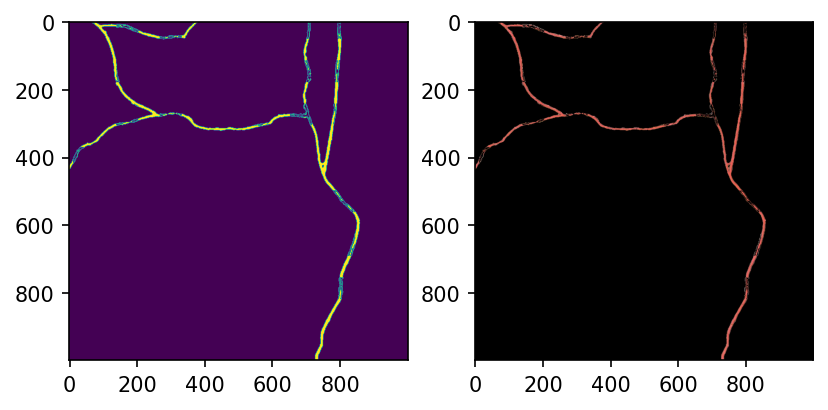

In [ ]:
roads = np.empty(data.shape)
roads[data==3] = 1
roads = roads[300:1300, 4500:5500]
roads = roads.astype(np.uint8)
fig, axs = plt.subplots(1, 2, dpi=150)
tempmap = mapdata[300:1300, 4500:5500,:].copy()
tempmap[roads != 1] = 0
axs[0].imshow(roads)
axs[1].imshow(tempmap)

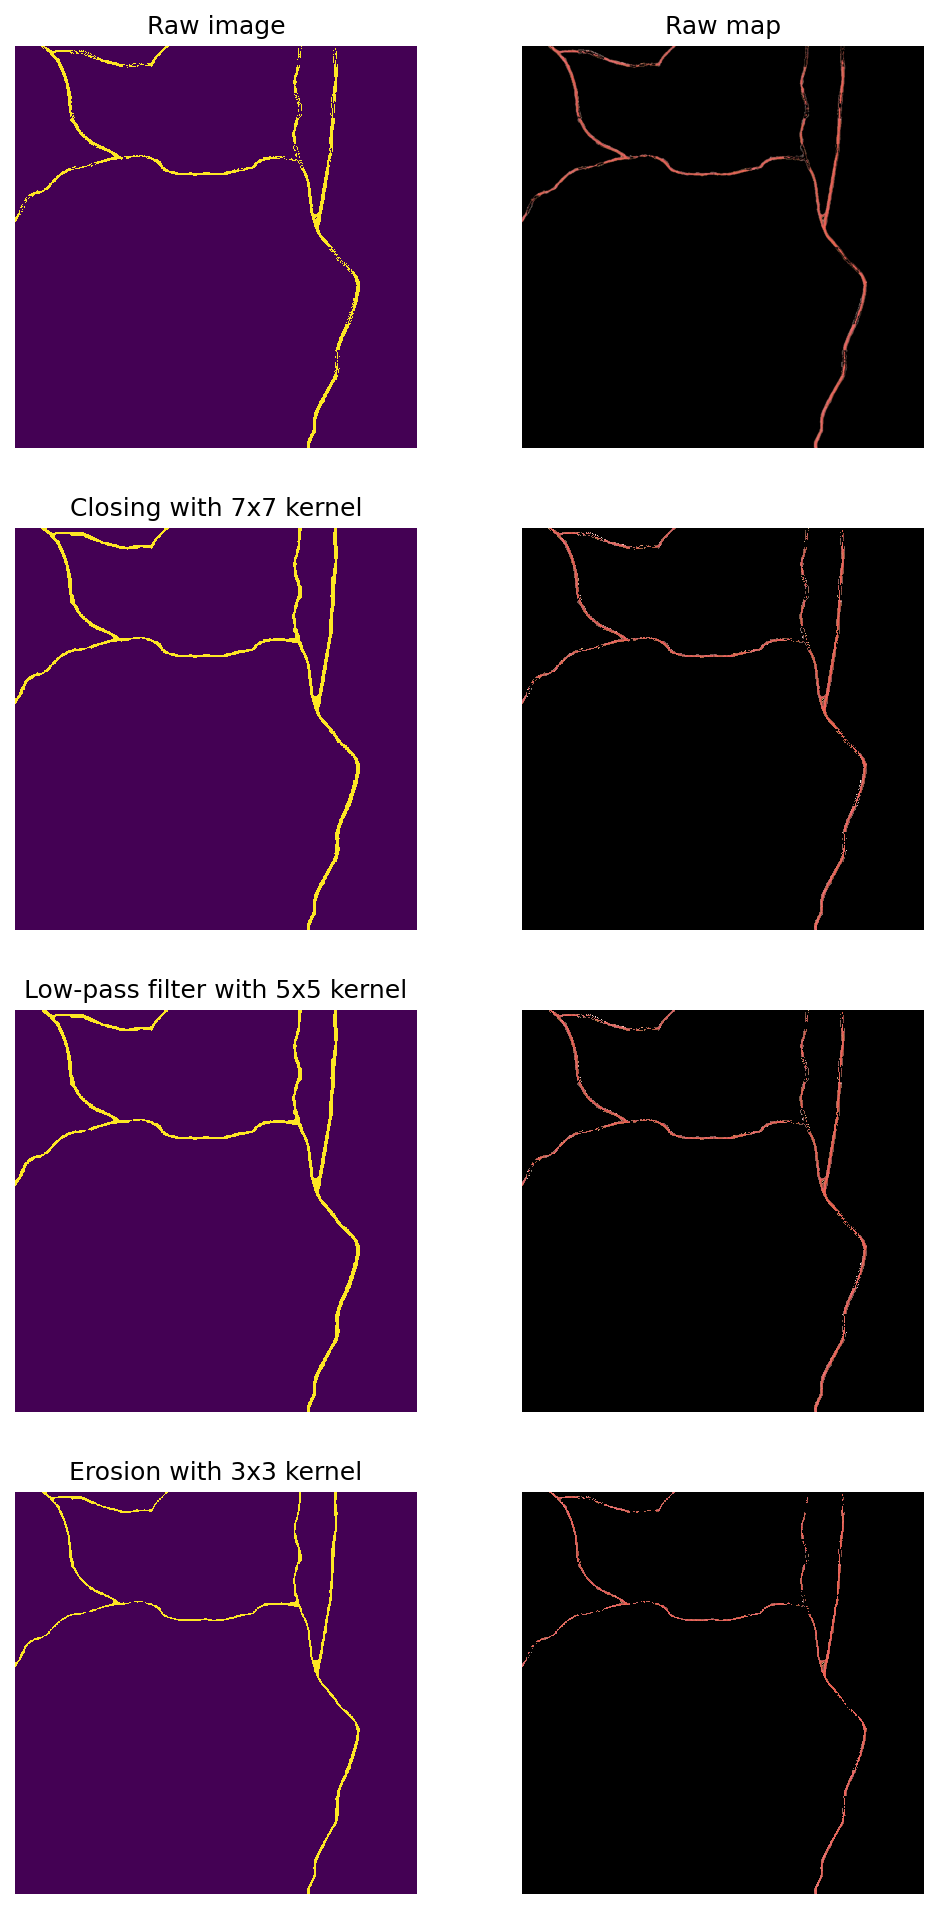

In [ ]:
fig, axs = plt.subplots(4,2, dpi=150, figsize=(8,16))
for a in axs.flatten(): a.axis('off')
    
axs[0,0].imshow(roads, interpolation='none')
axs[0,0].set_title('Raw image')
axs[0,1].set_title('Raw map')
axs[0,1].imshow(tempmap)

kernel = np.ones((7,7), np.uint8)
open_ex = cv2.morphologyEx(roads, cv2.MORPH_CLOSE, kernel)
temp_open = tempmap.copy()
temp_open[open_ex != 1] = 0
axs[1,0].imshow(open_ex, interpolation='none')
axs[1,0].set_title('Closing with 7x7 kernel')
axs[1,1].imshow(temp_open, interpolation='none')

lpf_kernel = np.ones((5,5), np.float32)/25
lpf_ex = cv2.filter2D(open_ex, -1, lpf_kernel)
temp_lpf = temp_open.copy()
temp_lpf[lpf_ex == 0] = 0
axs[2,0].imshow(lpf_ex, interpolation='none')
axs[2,0].set_title('Low-pass filter with 5x5 kernel')
axs[2,1].imshow(temp_lpf, interpolation='none')

eroded = cv2.erode(lpf_ex, np.ones((3,3), np.uint8), iterations=1)
temp_er = temp_open.copy()
temp_er[eroded != 1] = 0
axs[3,0].imshow(eroded, interpolation='none')
axs[3,0].set_title('Erosion with 3x3 kernel')
axs[3,1].imshow(temp_er, interpolation='none')

plt.show()

Next step is to skeletonize roads in order to generate line geometries from them.

In [ ]:
from skimage.morphology import skeletonize

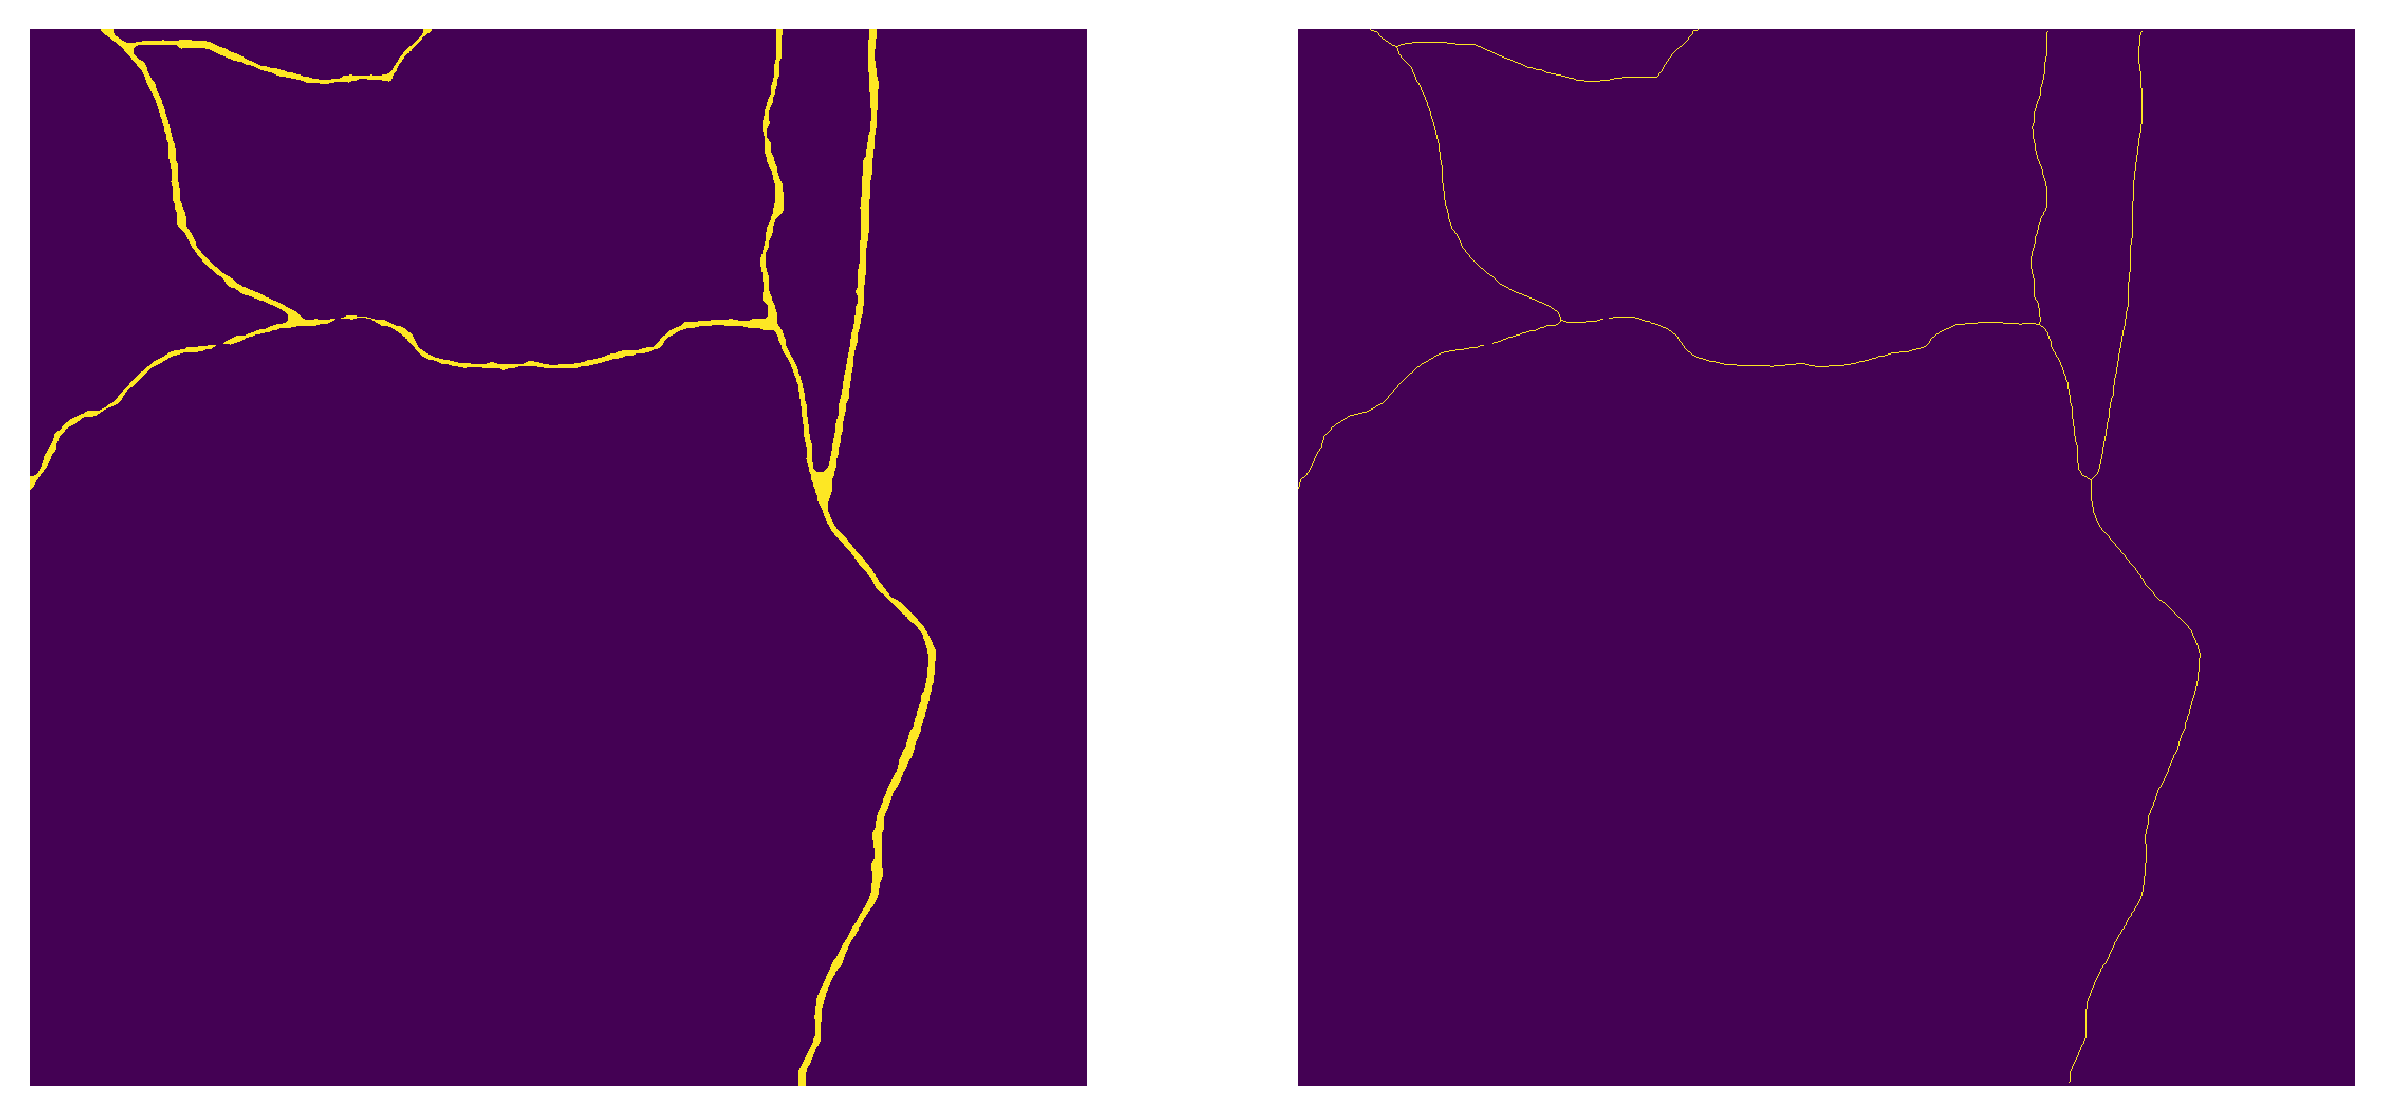

In [ ]:
skeletonized = skeletonize(eroded)

fig, axs = plt.subplots(1,2, figsize=(10,5), dpi=300)
for a in axs: a.axis('off')

axs[0].imshow(eroded, interpolation='none')
axs[1].imshow(skeletonized, interpolation='none')
plt.show()

These are then polygonized and merged into polygon data, that can then be used to get line geometries.

## Waterways

<matplotlib.image.AxesImage>

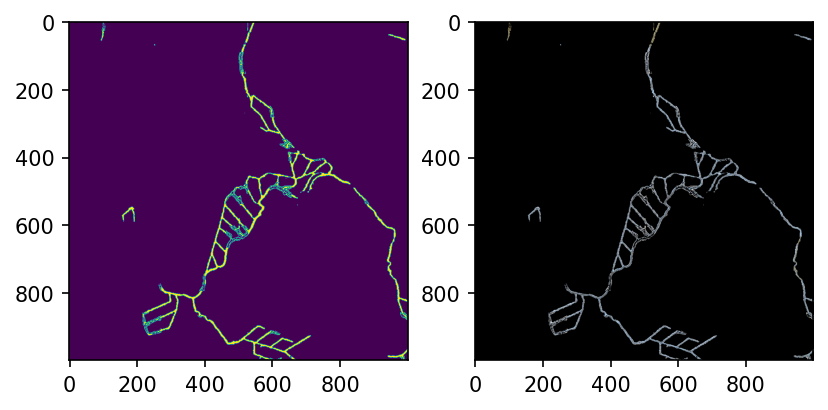

In [ ]:
waterways = np.empty(data.shape)
waterways[data==4] = 1
waterways = waterways[2500:3500,2000:3000]
waterways = waterways.astype(np.uint8)
fig, axs = plt.subplots(1, 2, dpi=150)
tempmap = mapdata[2500:3500, 2000:3000,:].copy()
tempmap[waterways != 1] = 0
axs[0].imshow(waterways)
axs[1].imshow(tempmap)

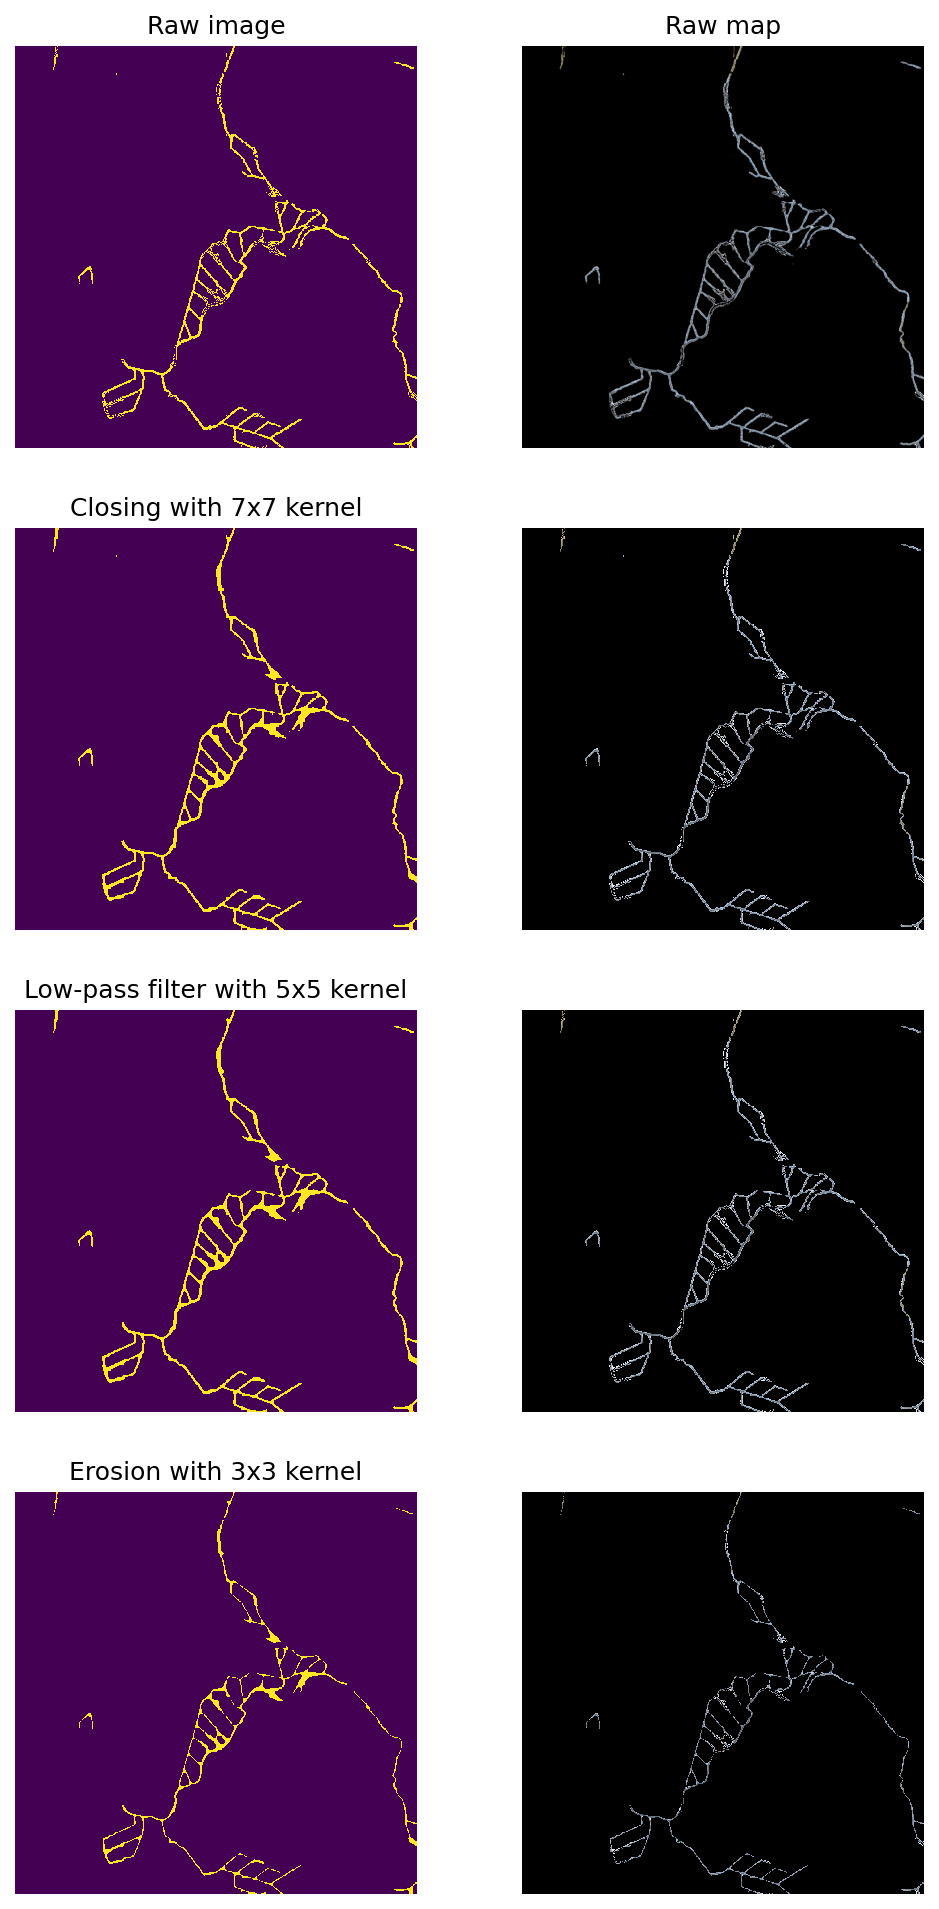

In [ ]:
fig, axs = plt.subplots(4,2, dpi=150, figsize=(8,16))
for a in axs.flatten(): a.axis('off')
    
axs[0,0].imshow(waterways, interpolation='none')
axs[0,0].set_title('Raw image')
axs[0,1].set_title('Raw map')
axs[0,1].imshow(tempmap)

kernel = np.ones((7,7), np.uint8)
open_ex = cv2.morphologyEx(waterways, cv2.MORPH_CLOSE, kernel)
temp_open = tempmap.copy()
temp_open[open_ex != 1] = 0
axs[1,0].imshow(open_ex, interpolation='none')
axs[1,0].set_title('Closing with 7x7 kernel')
axs[1,1].imshow(temp_open, interpolation='none')

lpf_kernel = np.ones((5,5), np.float32)/25
lpf_ex = cv2.filter2D(open_ex, -1, lpf_kernel)
temp_lpf = temp_open.copy()
temp_lpf[lpf_ex == 0] = 0
axs[2,0].imshow(lpf_ex, interpolation='none')
axs[2,0].set_title('Low-pass filter with 5x5 kernel')
axs[2,1].imshow(temp_lpf, interpolation='none')

eroded = cv2.erode(lpf_ex, np.ones((3,3), np.uint8), iterations=1)
temp_er = temp_open.copy()
temp_er[eroded != 1] = 0
axs[3,0].imshow(eroded, interpolation='none')
axs[3,0].set_title('Erosion with 3x3 kernel')
axs[3,1].imshow(temp_er, interpolation='none')

plt.show()

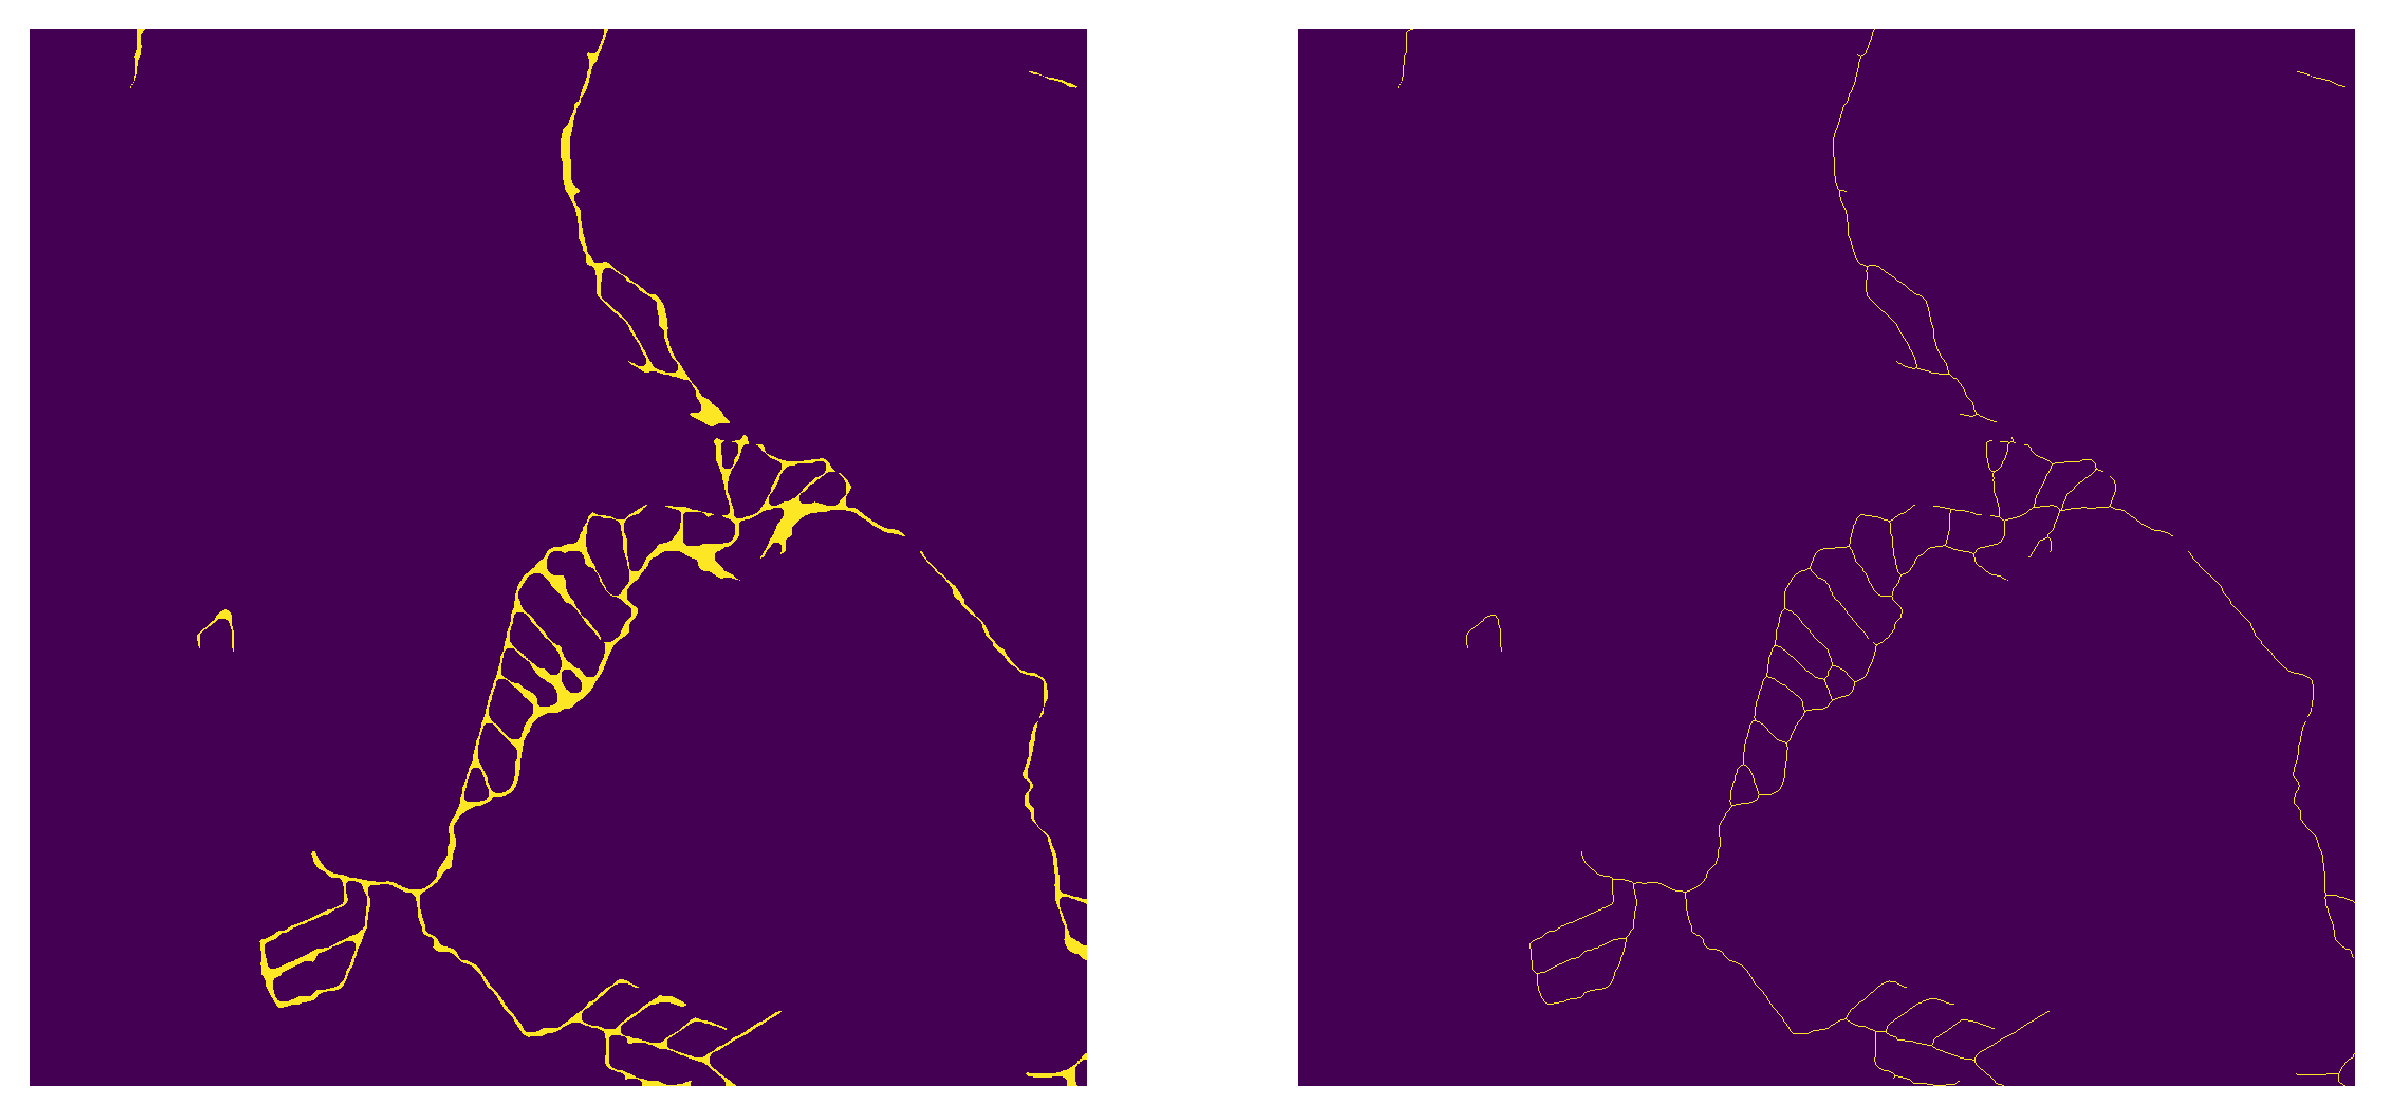

In [ ]:
skeletonized = skeletonize(eroded)

fig, axs = plt.subplots(1,2, figsize=(10,5), dpi=300)
for a in axs: a.axis('off')

axs[0].imshow(eroded, interpolation='none')
axs[1].imshow(skeletonized, interpolation='none')
plt.show()

## Water bodies

<matplotlib.image.AxesImage>

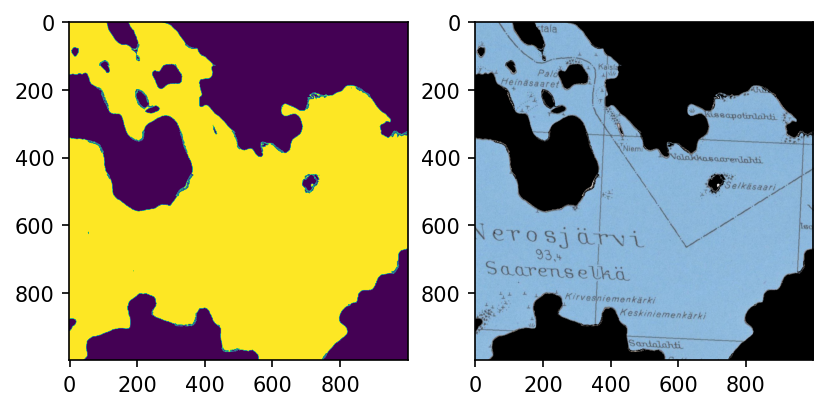

In [ ]:
waterbodies = np.empty(data.shape)
waterbodies[data==5] = 1
waterbodies = waterbodies[1500:2500, 1000:2000]
waterbodies = waterbodies.astype(np.uint8)
fig, axs = plt.subplots(1, 2, dpi=150)
tempmap = mapdata[1500:2500, 1000:2000,:].copy()
tempmap[waterbodies != 1] = 0
axs[0].imshow(waterbodies)
axs[1].imshow(tempmap)

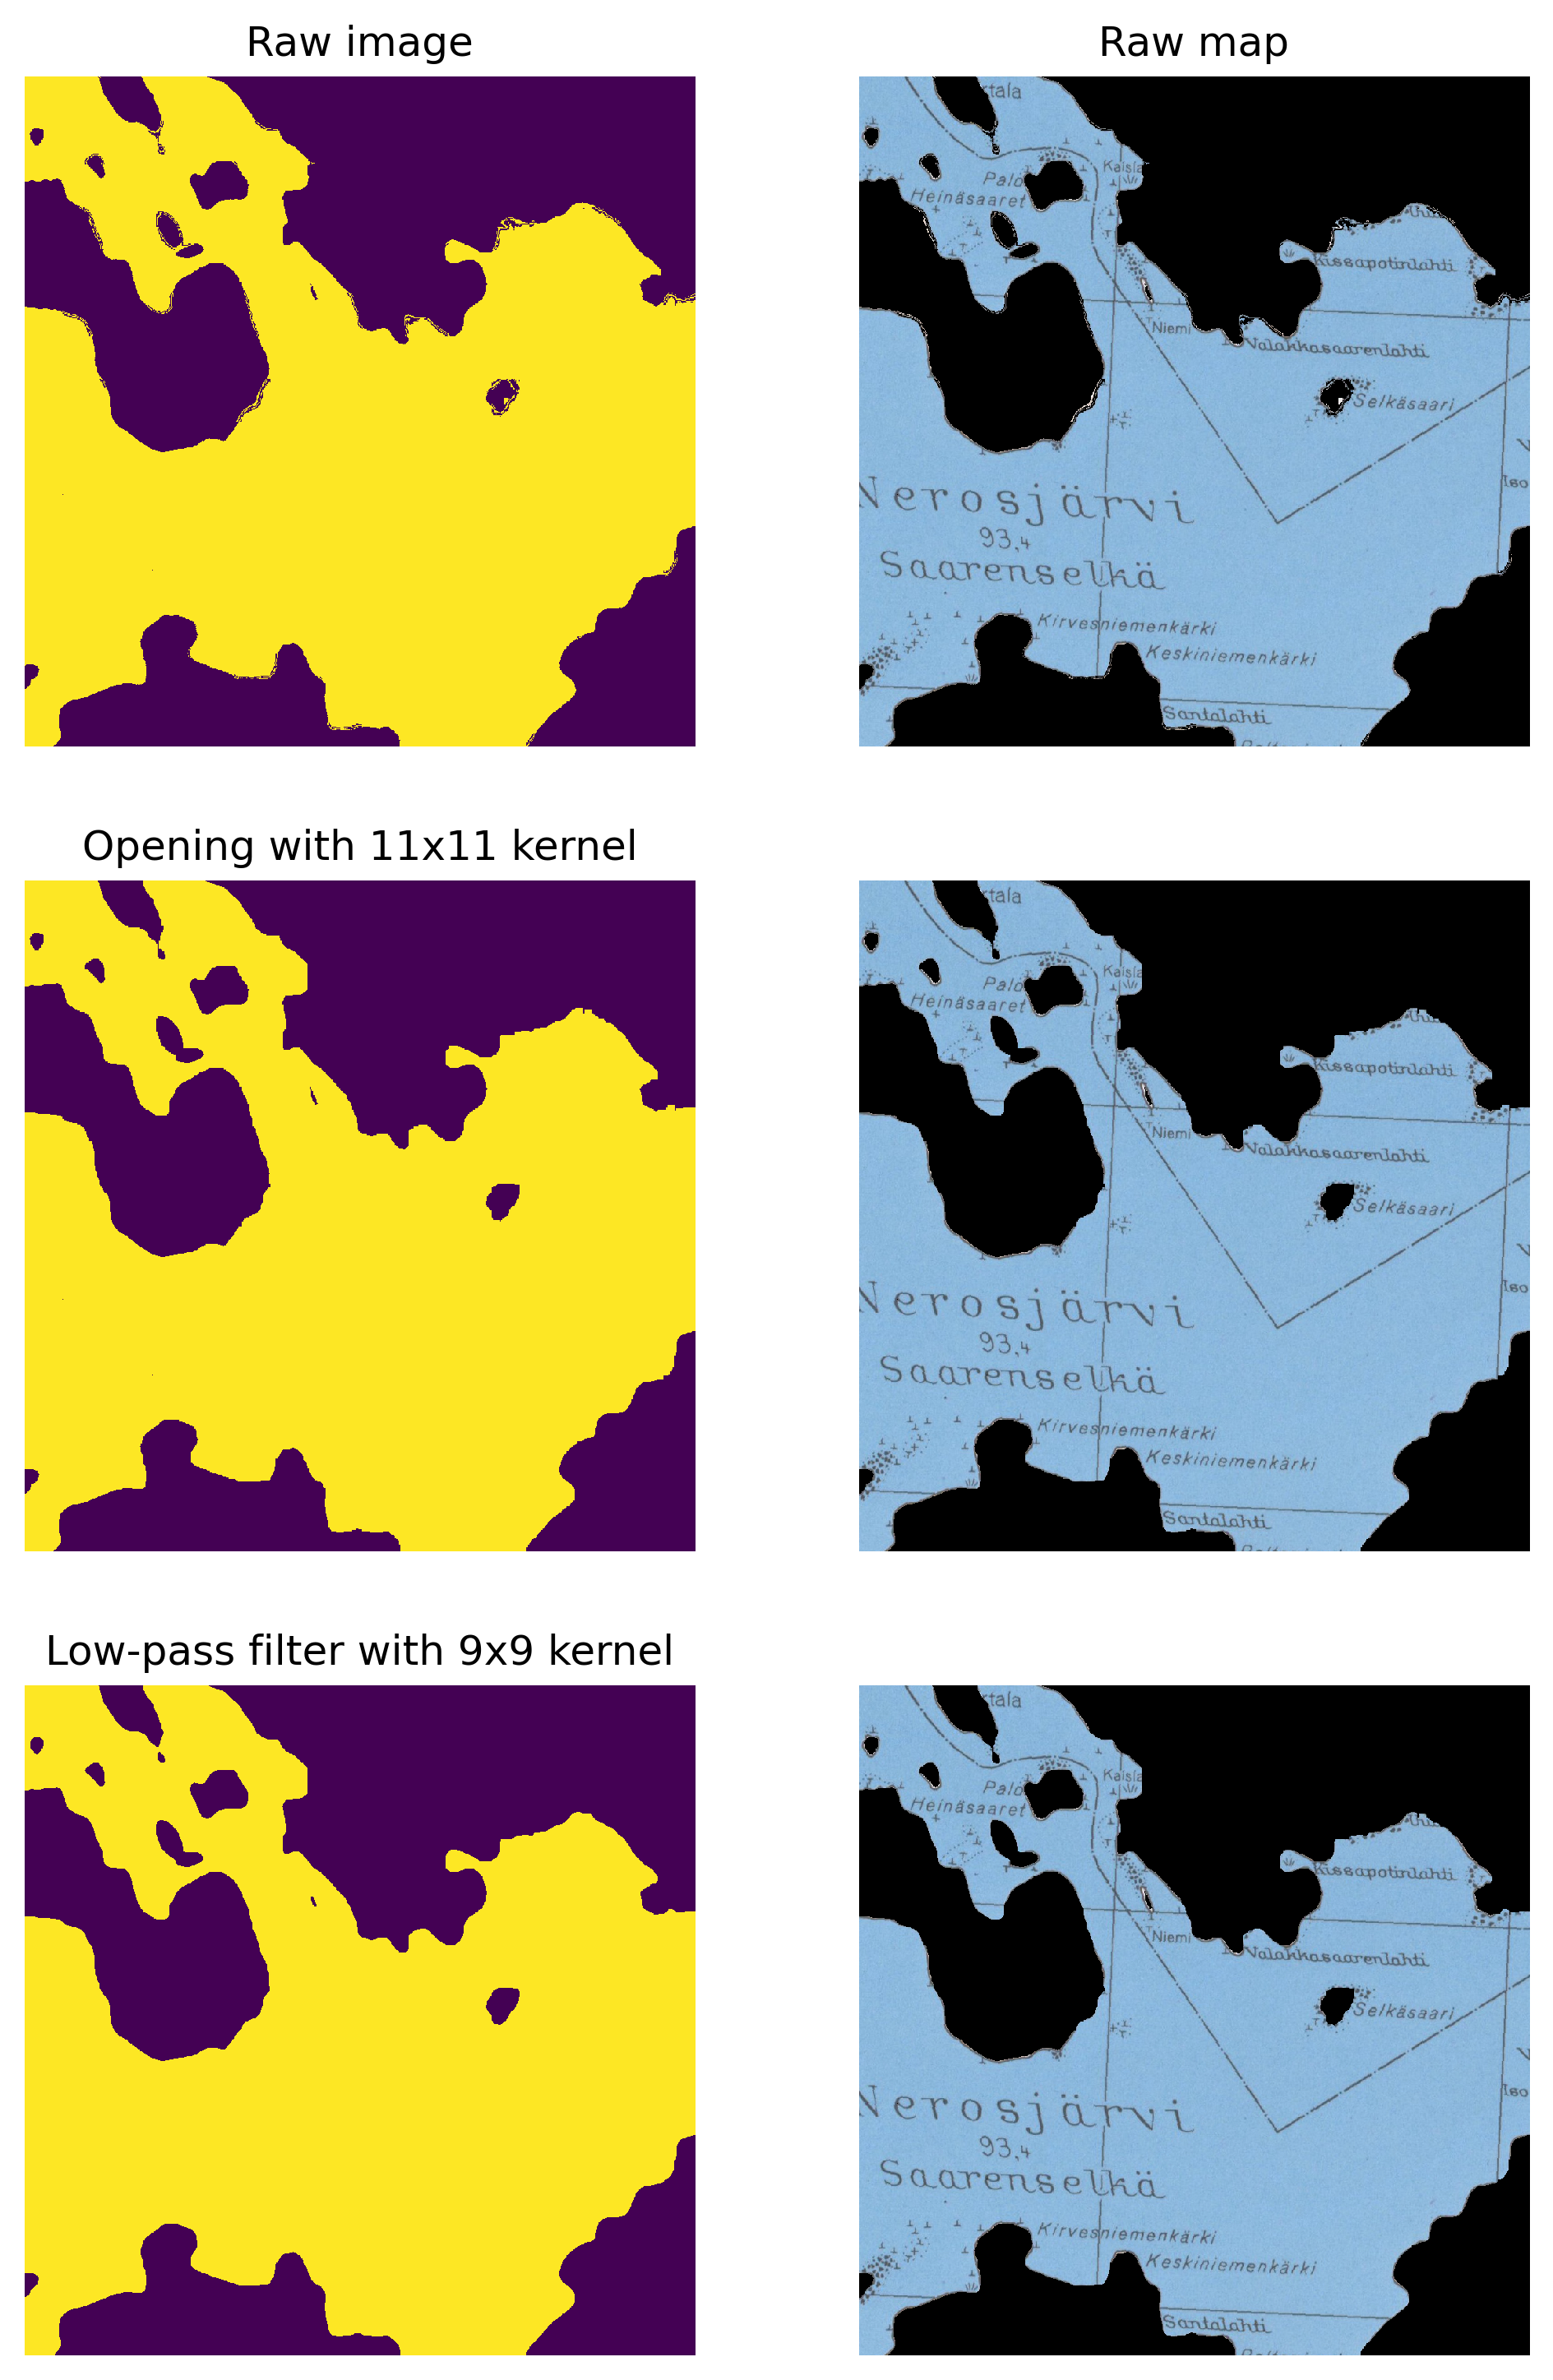

In [ ]:
fig, axs = plt.subplots(3,2, dpi=300, figsize=(8,12))
for a in axs.flatten(): a.axis('off')
    
axs[0,0].imshow(waterbodies, interpolation='none')
axs[0,0].set_title('Raw image')
axs[0,1].set_title('Raw map')
axs[0,1].imshow(tempmap, interpolation='none')
kernel = np.ones((11,11), np.uint8)
open_ex = cv2.morphologyEx(waterbodies, cv2.MORPH_OPEN, kernel)
axs[1,0].imshow(open_ex, interpolation='none')
axs[1,0].set_title('Opening with 11x11 kernel')

temp_open = tempmap.copy()
temp_open[open_ex == 0] = 0

axs[1,1].imshow(temp_open, interpolation='none')

lpf_kernel = np.ones((7,7), np.float32)/49

lpf_ex = cv2.filter2D(open_ex, -1, lpf_kernel)

axs[2,0].imshow(lpf_ex, interpolation='none')
axs[2,0].set_title('Low-pass filter with 9x9 kernel')

temp_lpf = temp_open.copy()
temp_lpf[lpf_ex == 0] = 0

axs[2,1].imshow(temp_lpf, interpolation='none')

plt.show()

## All together:

In [ ]:
def run_postproc_chain(inpath, outpath):
    with rio.open(inpath) as src:
        data = src.read()[0]
        prof = src.profile
    fields = np.where((data==1) | (data==4), 1, 0).astype(np.uint8)
    marshes = np.where((data==2) | (data==4), 1, 0).astype(np.uint8)
    roads = np.where(data==3, 1, 0).astype(np.uint8)
    waterways = np.where(data==4, 1, 0).astype(np.uint8)
    waterbodies = np.where(data==5, 1, 0).astype(np.uint8)
    
    er_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (11,11))
    dil_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11,11))
    
    fields = cv2.erode(fields, er_kernel)
    fields = cv2.dilate(fields, dil_kernel)
    fields = cv2.filter2D(fields, -1,  np.ones((7,7), np.float32)/49)

    marshes = cv2.erode(marshes, er_kernel)
    marshes = cv2.dilate(marshes, dil_kernel)    
    marshes = cv2.filter2D(marshes, -1,  np.ones((7,7), np.float32)/49)
    
    roads = cv2.morphologyEx(roads, cv2.MORPH_CLOSE, np.ones((7,7), np.uint8))
    roads = cv2.filter2D(roads, -1, np.ones((5,5), np.float32)/25)
    roads = cv2.erode(roads, np.ones((3,3), np.uint8), iterations=1)

    waterways = cv2.morphologyEx(waterways, cv2.MORPH_CLOSE, np.ones((7,7), np.uint8))
    waterways = cv2.filter2D(waterways, -1, np.ones((5,5), np.float32)/25)
    waterways = cv2.erode(waterways, np.ones((3,3), np.uint8), iterations=1)
    
    waterbodies = cv2.morphologyEx(waterbodies, cv2.MORPH_OPEN, np.ones((11,11), np.uint8))
    waterbodies = cv2.filter2D(waterbodies, -1,  np.ones((7,7), np.float32)/49)
    
    prof.update({'count': 5})

    with rio.open(outpath, 'w', **prof) as dest:
        dest.write(fields, 1)
        dest.write(marshes, 2)
        dest.write(roads, 3)
        dest.write(waterways, 4)
        dest.write(waterbodies, 5)

In [ ]:
from tqdm import tqdm
from pathlib import Path
import os

indir = Path('../results/raw/')
outdir = Path('../results/processed/')
for f in tqdm(os.listdir(indir)):
    run_postproc_chain(indir/f, outdir/f)

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:45<00:00,  2.50s/it]


# Generate polygon and line data

In [ ]:
import fiona
from rasterio import features
import geopandas as gpd
from centerline.geometry import Centerline
import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm
tqdm.pandas()

For roads and waterways, raster data is not that useful. These classes are converted into line geometries using the following steps:

1. Skeletonize the rasters
2. Polygonize the skeletonized rasters
3. Buffer these polygons by 10 meters and merge touching polygons
4. Erode these polygons by 10 meters
5. Use `centerline` library to convert polygons into line geometries

## Roads

In [ ]:
skel_dir = Path('../results/skeletonized/')
poly_dir = Path('../results/polygons/')
line_dir = Path('../results/lines/')
for f in (os.listdir(outdir)):
    with rio.open(outdir/f) as src:
        prof = src.profile
        im = src.read(3)
    temp = np.zeros(im.shape)
    skeletonized = skeletonize(im)
    prof.update({'count':1})
    with rio.open(skel_dir/'roads'/f, 'w', **prof) as dest:
        dest.write(skeletonized[None])
    with rio.open(skel_dir/'roads'/f) as src:
        im = src.read(1)
        mask = im == 1
        results = ({'properties': {'raster_val': v}, 'geometry': s}
                   for i, (s, v) in enumerate(features.shapes(im,mask=mask,transform=src.transform)))
        with fiona.open(str(poly_dir/'roads'/f.replace('tif', 'geojson')), 
                        'w', driver='GeoJSON',
                        crs='EPSG:3067',
                        schema={'properties': [('raster_val', 'int')],
                                'geometry': 'Polygon'}) as dst:
            dst.writerecords(results)
    polys = gpd.read_file(poly_dir/'roads'/f.replace('tif', 'geojson'))
    polys['geometry'] = polys.geometry.buffer(10)
    union_geoms = polys.geometry.unary_union
    union_gdf = gpd.GeoDataFrame({'geometry': union_geoms}, crs=polys.crs)
    union_gdf['geometry'] = union_gdf.geometry.buffer(-10)
    union_gdf['geometry'] = union_gdf.geometry.simplify(1)
    union_gdf.to_file(poly_dir/'roads'/f.replace('tif', 'geojson'))
    
    lines = union_gdf.copy()
    lines['geometry'] = lines.geometry.progress_apply(lambda row: Centerline(row))
    lines.to_file(line_dir/'roads'/f.replace('tif', 'geojson'))

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

## Waterways

In [ ]:

for f in tqdm(os.listdir(outdir)):
    with rio.open(outdir/f) as src:
        prof = src.profile
        im = src.read(1)
    temp = np.zeros(im.shape)
    temp[im==4] = 1
    skeletonized = skeletonize(temp)
    with rio.open(skel_dir/'waterways'/f, 'w', **prof) as dest:
        dest.write(skeletonized[None])
    with rio.open(skel_dir/'waterways'/f) as src:
        im = src.read(1)
        mask = im == 1
        results = ({'properties': {'raster_val': v}, 'geometry': s}
                   for i, (s, v) in enumerate(features.shapes(im,mask=mask,transform=src.transform)))
        with fiona.open(str(poly_dir/'waterways'/f.replace('tif', 'geojson')), 
                        'w', driver='GeoJSON',
                        crs='EPSG:3067',
                        schema={'properties': [('raster_val', 'int')],
                                'geometry': 'Polygon'}) as dst:
            dst.writerecords(results)
    polys = gpd.read_file(poly_dir/'waterways'/f.replace('tif', 'geojson'))
    polys['geometry'] = polys.geometry.buffer(10)
    union_geoms = polys.geometry.unary_union
    union_gdf = gpd.GeoDataFrame({'geometry': union_geoms}, crs=polys.crs)
    union_gdf['geometry'] = union_gdf.geometry.buffer(-10)
    union_gdf['geometry'] = union_gdf.geometry.simplify(1)
    union_gdf.to_file(poly_dir/'waterways'/f.replace('tif', 'geojson'))
    
    lines = union_gdf.copy()
    lines['geometry'] = lines.geometry.progress_apply(lambda row: Centerline(row))
    lines.to_file(line_dir/'waterways'/f.replace('tif', 'geojson'))